# Demo Code for DecoR
Simple code that shows how DecoR can be applied to synthetic data.

In [9]:
from experiments.utils_experiments import plot_results, get_data
from numpy.typing import NDArray
from robust_deconfounding import DecoR
from robust_deconfounding.robust_regression import Torrent, BFS

import numpy as np
import random
import matplotlib.pylab as plt
import statsmodels.api as sm

seed = 2
np.random.seed(seed)
random.seed(seed)
ibm_cb = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#808080"]

We specify the data generating process and the hyperparameters for DecoR.

The "process_type" can either be an Ornstein-Uhlenbeck process or a band-limited process.\
The "basis_type" is the basis for which the confounder is sparse. This is also the basis used by DecoR.\
The "fraction" variable is the fraction of outliers. For example "0.25" means that a fourth of the datapoints is confounded in the "basis"-domain.\
The "beta" variable is the $\beta$ value i.e. the true causal effect. It can be two- or one-dimensional.\
The "noise_var" is the variance of the noise i.e. $\sigma_{\eta}^2$.\
The "band" variable is the indices of the band for the band-limited process. Does nothing if "ou" is selected for the "process_type".

The "a" variable is the upper bound for the fraction of inliers in the data.\
The "method" variable can either be "torrent" or "bfs" the two robust-regression algorithms implemented. DecoR can be easily extended to include other robust regression techniques.

The "m" is the number of times we resample the data to get confidence intervals.\
The "num_data" variable is a list of increasing natural numbers that indicate the amount of data tested on.

In [10]:
data_args = {
    "process_type": "blp",       # "ou" | "blp
    "basis_type": "cosine",     # "cosine" | "haar"
    "fraction": 0.25,
    "beta": np.array([[3.]]),
    "noise_var": 1,
    "band": list(range(0, 50))  # list(range(0, 50)) | None
}

method_args = {
    "a": 0.7,
    "method": "torrent", #"torrent" | "bfs" | "ols"
}

m = 1000
num_data = [4 * 2 ** k for k in range(0, 5)] + [1024]

We plot the results:

number of data points:  4
number of data points:  8
number of data points:  16
number of data points:  32
number of data points:  64
number of data points:  1024


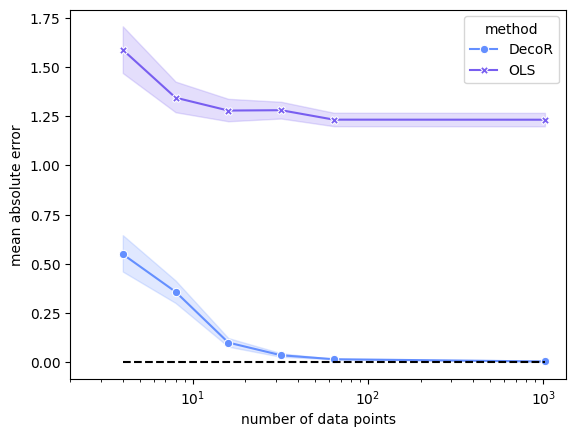

In [11]:
def get_results(x: NDArray, y: NDArray, basis: NDArray, a: float, method: str) -> NDArray:
    if method == "torrent" or method == "bfs":
        if method == "torrent":
            algo = Torrent(a=a, fit_intercept=False)
        elif method == "bfs":
            algo = BFS(a=a, fit_intercept=False)

        algon = DecoR(algo, basis)
        algon.fit(x, y)

        return algon.estimate

    elif method == "ols":
        model_l = sm.OLS(y, x).fit()
        return model_l.params

    else:
        raise ValueError("Invalid method")

res = {
    "DecoR": [],
    "ols": []
}

for n in num_data:
    print("number of data points: ", n)
    res["DecoR"].append([])
    res["ols"].append([])
    for _ in range(m):
        data_values = get_data(n, **data_args)

        estimates_decor = get_results(**data_values, **method_args)
        res["DecoR"][-1].append(np.linalg.norm(estimates_decor - data_args["beta"].T, ord=1))

        estimates_ols = get_results(**data_values, method="ols", a=method_args["a"])
        res["ols"][-1].append(np.linalg.norm(estimates_ols - data_args["beta"].T, ord=1))

res["DecoR"], res["ols"] = np.array(res["DecoR"]), np.array(res["ols"])

plot_results(res, num_data, m, colors=[ibm_cb[0], ibm_cb[1]])

plt.xlabel("number of data points")
plt.ylabel("mean absolute error")

plt.xscale('log')
plt.xlim(left=num_data[0] - 2)
plt.hlines(0, num_data[0], num_data[-1], colors='black', linestyles='dashed')

plt.show()